# Tutorial 4 - Setting parameter values

In Tutorial 1 and Tutorial 2, we saw how to run a PyBaMM model with all the default settings. However, PyBaMM also allows you to tweak these settings for your application. In this tutorial, we will see how to change the parameters in PyBaMM.

In [2]:
import pybamm

## Change the whole parameter set

PyBaMM has a number of in-built parameter sets (check the list here), which can be selected doing

In [3]:
parameter_values = pybamm.ParameterValues("Chen2020")

The parameter values are stored in a dictionary-like object of class pybamm.ParameterValues.

In [4]:
parameter_values

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008 at 0x0000027AF8703910>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008 at 0x0000027AF8703C70>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212331001,
 'Ideal gas constant [J.K-1.mol-1]': 8.31446261815324,
 'Initial SEI thickness [m]': 5e-09,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in

and the specific values can be accessed using standard dictionary syntax:

In [5]:
parameter_values.search("electrolyte")

Results for 'electrolyte': ['EC initial concentration in electrolyte [mol.m-3]', 'Negative electrode Bruggeman coefficient (electrolyte)', 'Positive electrode Bruggeman coefficient (electrolyte)', 'Separator Bruggeman coefficient (electrolyte)', 'Initial concentration in electrolyte [mol.m-3]', 'Electrolyte diffusivity [m2.s-1]', 'Electrolyte conductivity [S.m-1]']
EC initial concentration in electrolyte [mol.m-3] -> 4541.0
Negative electrode Bruggeman coefficient (electrolyte) -> 1.5
Positive electrode Bruggeman coefficient (electrolyte) -> 1.5
Separator Bruggeman coefficient (electrolyte) -> 1.5
Initial concentration in electrolyte [mol.m-3] -> 1000.0
Electrolyte diffusivity [m2.s-1] -> <function electrolyte_diffusivity_Nyman2008 at 0x0000027AF8703C70>
Electrolyte conductivity [S.m-1] -> <function electrolyte_conductivity_Nyman2008 at 0x0000027AF8703910>


To run a simulation with a given parameter set, we can proceed as usual but passing the parameters as the parameter_values keyword argument

In [7]:
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve([0, 3600])
sim.plot()

c:\Users\RamonSchindler\miniconda3\envs\pybamm_env\lib\site-packages\pybamm\simulation.py:120: UserWarning: The default solver changed to IDAKLUSolver after the v25.4.0. release. You can swap back to the previous default by using `pybamm.CasadiSolver()` instead.
  self._solver = solver or self._model.default_solver


interactive(children=(FloatSlider(value=0.0, description='t', max=3555.4443163221113, step=35.554443163221116)…

## Change individual parameters

We often want to quickly change a small number of parameter values to investigate how the behaviour or the battery changes. In such cases, we can change parameter values directly in notebook or script we are working in as we demonstrate in this section.

Parameters can either have a constant value or be a function of a model variable. These dependencies are hardcoded into the PyBaMM models. In order to check what are the specific parameters that a model requires, and whether they must be constants or they can be functions, we can call the print_parameter_info method.

In [8]:
model.print_parameter_info()

┌───────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Parameter                                                 │ Type of parameter                                                                                                                                                                                           │
├───────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Nominal cell capacity [A.h]                               │ Parameter                                                                                                                             

The table shows all the parameters that need to be provided to the model (in this case DFN). For example, we see that we need to define (amongst others) the Negative electrode thickness [m], which is defined to be a Parameter. This means it can only have a constant value. In contrast, other parameters are defined to be a FunctionParameter, which means that they can depend on model variables. For example, the Current function [A] is a FunctionParameter that can depend on Time [s].

Note that a FunctionParameter can always be defined to be a constant (i.e. like if it was a Parameter), but a Parameter cannot be defined to be a function. This is because these dependencies are hardcoded in the model definitions.

## Constant Parameters

Let's start with a simple example: change the Current function [A] to be 10 A. To do this, we can simply update the value in the dictionary:

In [9]:
parameter_values["Current function [A]"] = 10

Note that, as we mentioned above, even though Current function [A] could depend on time, we can always define it to be a function.

Now we just need to run the simulation with the new parameter values

In [11]:
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve([0, 3600])
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1703.0698908157638, step=17.03069890815764),…

and we observe in the plot that now the applied current is indeed 10 A. Note that we still passed the interval [0, 3600] to sim.solve(), but the simulation terminated early as the lower voltage cut-off was reached.

## Function parameters

Let's now illustrate how to change the Current function [A] to be a given time-dependent function. In this case we will set the current to be sinusoidal. To do this, we need to define the relevant function and pass it as a parameter.

In [12]:
import numpy as np


def my_current(t):
    return pybamm.sin(2 * np.pi * t / 60)


parameter_values["Current function [A]"] = my_current

ote that the my_current function takes an argument t, which is time. PyBaMM will assume that the arguments are defined exactly as in the print_parameter_info table above, so the actual name given to the arguments does not matter, but the order does. For example, for the Electrolyte conductivity [S.m-1], it will assume that the first argument is Electrolyte concentration [mol.m-3] and the second is Temperature [K].

We can now solve the model again. In this case, we will pass t_eval to be an array of the points we want to evaluate our solution to the solver (rather than the start and end points only) to make sure we have enough time points to resolve the sinusoidal function in our output.

In [15]:
sim = pybamm.Simulation(model, parameter_values=parameter_values)
t_eval = np.arange(0, 241, 2)
sim.solve(t_eval=t_eval)
sim.plot((["Current [A]"], ["Voltage [V]"]))

interactive(children=(FloatSlider(value=0.0, description='t', max=36.17769846326161, step=0.36177698463261615)…

## Input parameters

If the value of a parameter is expected to change often (e.g. running a parameter sweep) is is more convenient to set a parameter as an "input parameter". This is a placeholder that can be filled in with a numerical value when the model is solved.

To set a parameter as an input parameter, we can set its value to the string [input] in the parameter values dictionary. For example, we can set the Current function [A] to be an input parameter and then run a parameter sweep over different current values like so:

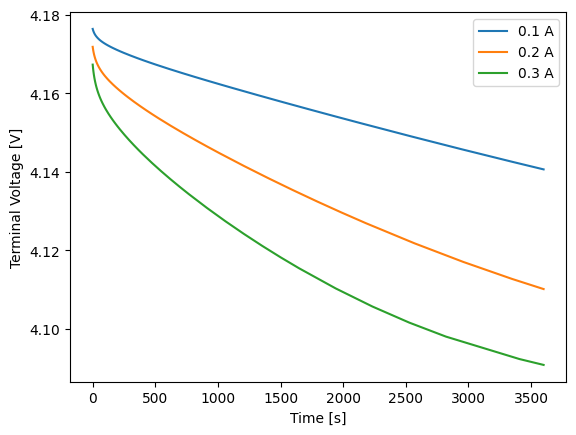

In [19]:
import matplotlib.pyplot as plt

parameter_values["Current function [A]"] = "[input]"
sim = pybamm.Simulation(model, parameter_values=parameter_values)
solns = []
for c in [0.1, 0.2, 0.3]:
    soln = sim.solve([0, 3600], inputs={"Current function [A]": c})
    plt.plot(soln["Time [s]"].entries, soln["Voltage [V]"].entries, label=f"{c} A")
    solns.append(soln["Terminal voltage [V]"].entries)
plt.xlabel("Time [s]")
plt.ylabel("Terminal Voltage [V]")
plt.legend()
plt.show()


## Define a new parameter set

We can also define a new parameter set from scratch, which is useful if there is a new battery or chemistry on which we need to run simulations repeatedly. To do so, we can initialise a ParameterValues object and pass as an argument a dictionary of parameter values:

In [20]:
def cube(t):
    return t**3

parameter_values = pybamm.ParameterValues(
    {
        "Negative eleectrode thickness [m]": 1e-4,
        "Positive electrode thickness [m]": 1.2e-4,
        "Current function [A]": cube,
    }
)

Note how, when we pass a function as a parameter, we pass the object without calling it, i.e. we pass cube rather than cube(t). This new parameter_values variable could now be passed to a simulation, but note that it is incomplete as it does not include all the parameters that the model needs to run (see the parameters needed by calling model.print_parameter_info(), as done above).

It is often convenient to define the parameter set in a separate file, and then call the parameters into your notebook or script. You can find some examples on how to do so in PyBaMM's parameter library. You can copy one of the parameter sets available into a new file and modify it accordingly for the new parameter set. Then, whenever the set is needed, one can import the get_parameter_values method from the corresponding file and call it to obtain a copy of the parameter values.

In this notebook we have seen how we can change the parameters of our model. In Tutorial 5 we show how can we define and run experiments.